# IMPORTS

In [1]:
import numpy as np 
import pandas as pd 

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier 
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, log_loss, balanced_accuracy_score

import matplotlib.pyplot as plt 
import seaborn as sns 

import warnings

import optuna 
from optuna.samplers import TPESampler
from tqdm import tqdm

plt.rcParams['axes.unicode_minus'] = False
plt.style.use('fivethirtyeight')
sns.set(font_scale = 1)
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

# DATA READ

In [2]:
train_df = pd.read_csv('./input/train.csv', index_col='Id')
test_df = pd.read_csv('./input/test.csv', index_col='Id')

display(train_df.shape, train_df.head(1), test_df.shape, test_df.head(1))

(4000000, 55)

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,3189,40,8,30,13,3270,206,234,193,4873,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


(1000000, 54)

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4000000,2763,78,20,377,88,3104,218,213,195,1931,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# EDA

In [3]:
train_info = pd.DataFrame(columns=['Name of Col', 'Num of Null', 'Dtype', 'N_unique'])

for i in range(0, len(train_df.columns)):
    train_info.loc[i] = [train_df.columns[i],
                       train_df[train_df.columns[i]].isnull().sum(),
                       train_df[train_df.columns[i]].dtypes,
                       train_df[train_df.columns[i]].nunique()]
    
train_info

,Name of Col,Num of Null,Dtype,N_unique
0,Elevation,0,int64,2525
1,Aspect,0,int64,440
2,Slope,0,int64,68
3,Horizontal_Distance_To_Hydrology,0,int64,1636
4,Vertical_Distance_To_Hydrology,0,int64,916
5,Horizontal_Distance_To_Roadways,0,int64,7760
6,Hillshade_9am,0,int64,301
7,Hillshade_Noon,0,int64,221
8,Hillshade_3pm,0,int64,326
9,Horizontal_Distance_To_Fire_Points,0,int64,8112


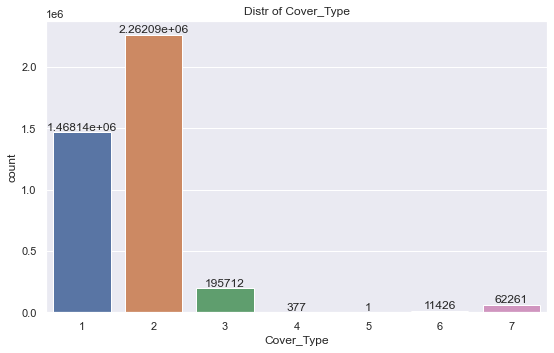

In [4]:
plt.figure(figsize=(8,5))
ax = sns.countplot(train_df['Cover_Type'])
ax.set_title('Distr of Cover_Type')
ax.bar_label(ax.containers[0])
plt.show()

In [5]:
features = train_df.columns[:-1]
target = train_df.columns[-1]

# VISUALIZATION

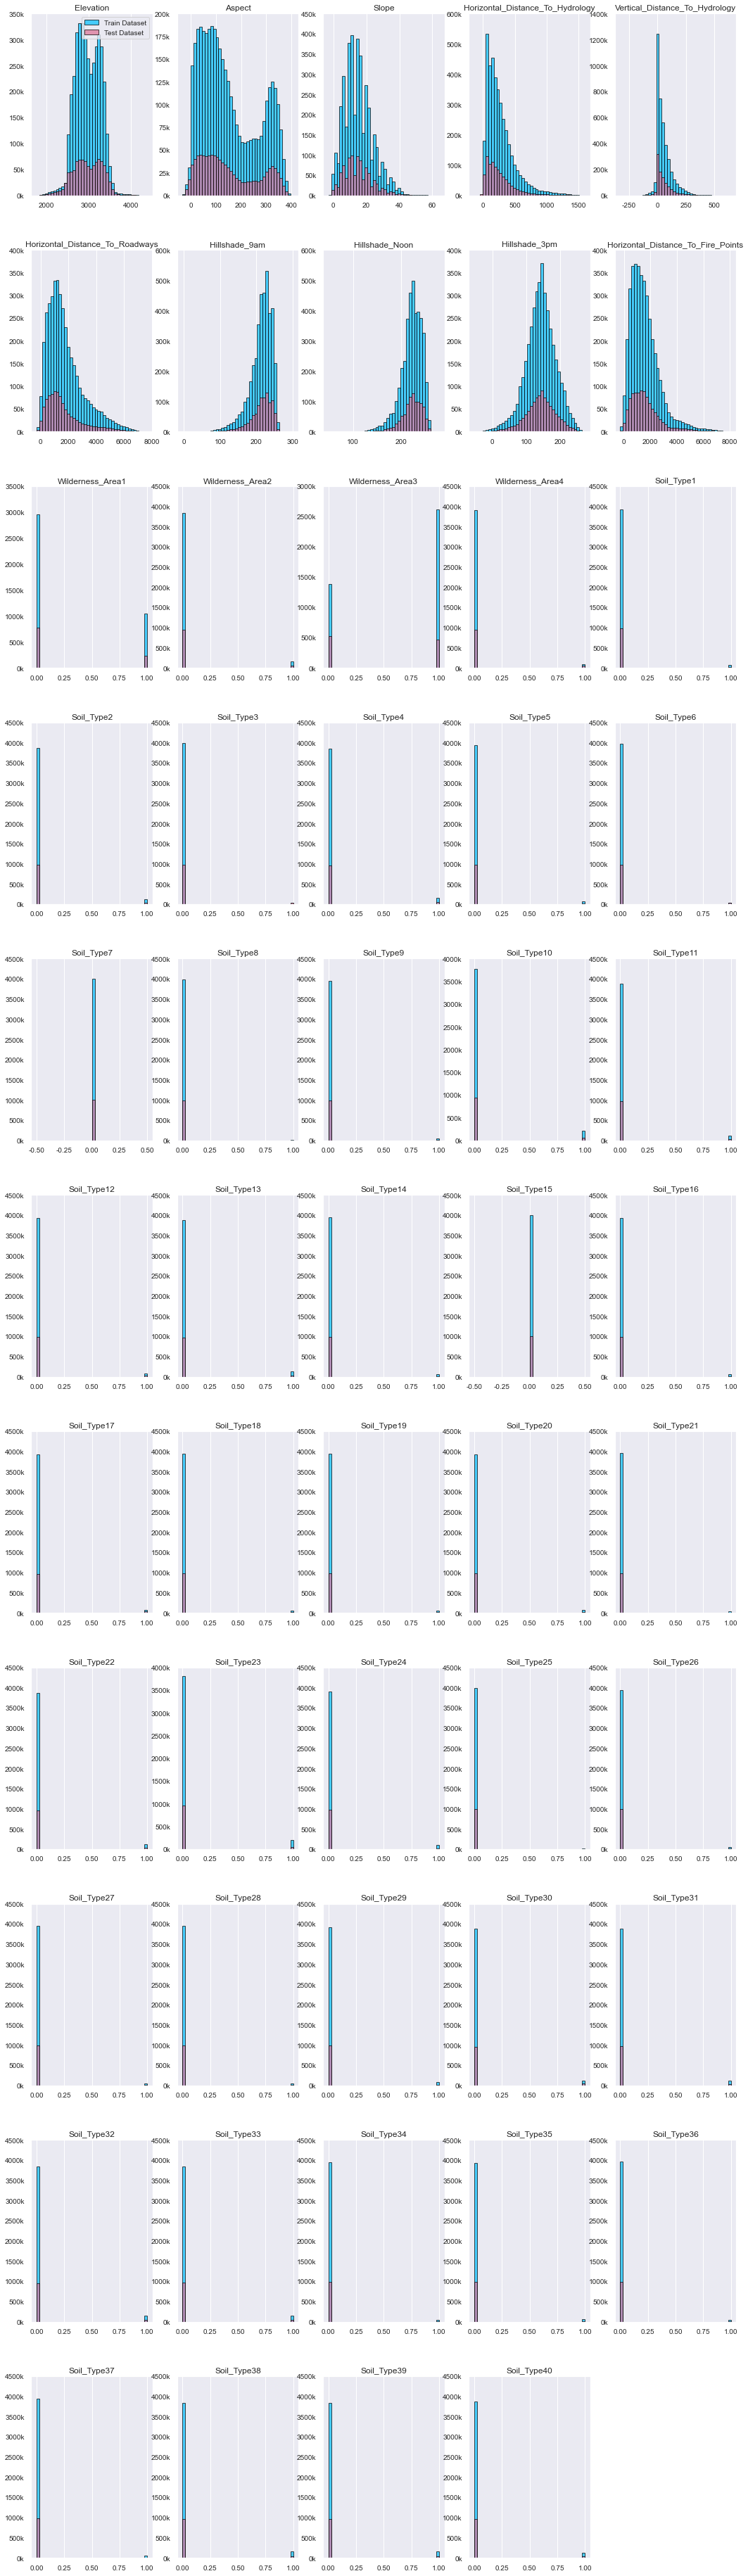

In [6]:
df = pd.concat([train_df[features], test_df[features]], axis=0)
columns = df.columns.values
cols = 5
rows = len(columns) // cols + 1

fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(16,62), sharex=False)
plt.subplots_adjust(hspace=0.3)

i = 0

for r in np.arange(0, rows, 1):
    for c in np.arange(0, cols, 1):
        if i >= len(columns):
            axs[r, c].set_visible(False)
        else:
            hist1 = axs[r, c].hist(train_df[columns[i]].values,
                                   range=(df[columns[i]].min(),
                                          df[columns[i]].max()),
                                   
                                   bins=40,
                                   color='deepskyblue',
                                   edgecolor='black',
                                   alpha=0.7,
                                   label='Train Dataset')
            
            hist2 = axs[r, c].hist(test_df[columns[i]].values,
                                   range=(df[columns[i]].min(),
                                          df[columns[i]].max()),
                                   
                                   bins=40,
                                   color='palevioletred',
                                   edgecolor='black',
                                   alpha=0.7,
                                   label='Test Dataset')
            
            axs[r, c].set_title(columns[i], fontsize=12, pad=5)
            axs[r, c].set_yticks(axs[r, c].get_yticks())
            axs[r, c].set_yticklabels([str(int(i / 1000)) + 'k' for i in axs[r, c].get_yticks()])
            axs[r, c].tick_params(axis='y', labelsize=10)
            axs[r, c].tick_params(axis='x', labelsize=10)
            axs[r, c].grid(axis='y')
            if i == 0:
                axs[r, c].legend(fontsize=10)
        
        i += 1
        
plt.show()

In [8]:
train_df.drop(['Soil_Type7', 'Soil_Type15'], axis=1, inplace=True)
test_df.drop(['Soil_Type7', 'Soil_Type15'], axis=1, inplace=True)
train_df = train_df.loc[train_df['Cover_Type'] != 5].reset_index(drop=True)

In [9]:
features = train_df.columns[:-1]
target = train_df.columns[-1]

trn = train_df.copy()
tst = test_df.copy()

In [10]:
num_features = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
                'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
                'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
                'Horizontal_Distance_To_Fire_Points']

In [11]:
ss = StandardScaler()

for col in num_features:
    trn[col] = ss.fit_transform(trn[[col]])
    tst[col] = ss.fit_transform(tst[[col]])
    
display(trn.head(5), tst.head(5))

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,0.722400,-1.014774,-0.830439,-1.065177,-0.566768,1.142708,-0.189778,0.581996,1.194297,2.919084,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1,0.158480,0.276592,-1.181451,0.038334,-0.332219,1.142708,0.687987,0.851886,-0.796612,3.406841,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2
2,0.435250,-1.260315,-0.947443,0.351731,-0.214944,0.872111,-0.124758,0.581996,-0.087208,3.270269,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
3,0.144641,1.131439,-0.245419,-0.350102,-0.522790,0.963324,-0.157268,0.761923,0.347588,1.139217,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2
4,-0.256676,0.312968,-0.245419,-0.023463,-0.434834,0.873631,0.622967,0.447052,0.301820,0.940567,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4000000,-0.602909,-0.664981,0.600277,0.494061,0.532977,1.011325,0.202692,-0.386123,1.214559,0.219114,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4000001,-0.419062,0.006883,-0.463930,-0.001615,-0.182141,-1.031701,0.234661,0.752728,0.179271,0.735520,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4000002,-0.063040,-0.853103,0.482031,-0.914009,-0.109170,-0.626587,-0.308810,-0.203907,0.509682,0.113523,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4000003,-0.127241,-0.297695,-1.055157,-0.466585,1.204312,0.307285,0.714194,0.843836,0.047107,-0.666860,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4000004,-0.815938,-1.274138,-1.291647,-0.992966,0.824862,1.364072,0.042848,-0.021691,1.963491,-1.018280,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
X_trn = trn[features]
y_trn = trn[target]
X_tst = tst[features]

display(X_trn.shape, y_trn.shape, X_tst.shape)

(3999999, 52)

(3999999,)

(1000000, 52)

In [13]:
RANDOM_SEED = 42
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)

preds_lgb = []
mean_acc = 0

model_lgb = LGBMClassifier(objective='multiclass', random_state=RANDOM_SEED)

for fold, (trn_idx, val_idx) in enumerate(skf.split(X_trn, y_trn)):
    
    X_train, X_val = X_trn.loc[trn_idx], X_trn.loc[val_idx]
    y_train, y_val = y_trn.loc[trn_idx], y_trn.loc[val_idx]
    
    model_lgb.fit(X_train, y_train, verbose=False, eval_set=[(X_train, y_train), (X_val, y_val)],
                  eval_metric='multi_logloss', early_stopping_rounds=100)
    
    y_pred = model_lgb.predict  (X_val)
    score = accuracy_score(y_val, y_pred)
    mean_acc += score
    
    print(f'Fold {fold} score: {score:.4f}')
    
    preds_lgb.append(model_lgb.predict(X_tst))
    
print('='*20)
print(f'Mean accuracy: {mean_acc / n_splits}')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt

